In [1]:
using LinearAlgebra
using Plots, Colors

We want to study the folloing (TV-JKO) scheme  
$$
\rho_{k+1}^{\tau} = \text{argmin TV}(\rho) + \frac{1}{2\tau}W^2_2\left(\rho_{k}^{\tau}, \rho\right), 
$$
where TV is the total variation functional
$$
\text{TV}(u):= \sup 
\left\{ 
\int_{\Omega}\text{div}z(x)u(x)d x: z \in C^1_c(\Omega; \mathbb{R}^N), \|z\|_{\infty} \le 1
\right\}
$$
and $W_2$ denotes the Wasserstein distance defined by the value of the optimal transport problem
$$
W_2^2(\mu, \nu) := \inf_{\gamma \in \Pi} \frac{1}{2}\int_{\Omega \times \Omega} |x - y|^2d \gamma(x,y).
$$

In order to solve this problem numerically, we use the discrete versions of such functionals, i.e.
$$
TV (u) 
\approx 
\|Du\|_1 = \max_{\| Z\|_{\infty} \le 1} Z\cdot Du,
\quad
\frac{1}{2}\int_{\Omega \times \Omega} |x - y|^2d \gamma(x,y) 
\approx \sum_{ij}C_ij\Gamma_{i,j}
$$
for $\Gamma \in \mathbb{R}^{MN\times MN}$ and $Z \in \mathbb{R}^{2\times MN}$. Here $D$ is the discret gradient operator and the matrix $C$ is a discrete version of the transportation cost, so that $C_{ij} = \frac{1}{2}|x_i - x_j|$, for $(x_i)$ being a discretization of the domain. 

Therefore the discrete version of our problem can be written in the form of a minmax problem and can be solved using a primal-dual algorithm.
$$
    \min_{\Gamma1 = \rho_0}\max_{\|Z\|_{\infty} \le \delta} C:\Gamma + \frac{1}{2\Delta t}Z: D\Gamma^{\top}1
$$

For this we will define a linear operator $K:\mathbb{R}^{MN\times MN} \to \mathbb{R}^{2\times MN}$
$$
Z:K\Gamma = K^{\top}Z:\Gamma = Z: D\Gamma^{\top}1
$$
and write the problem in the form

$$
    \min_{\Gamma1 = \rho_0}\max_{\|Z\|_{\infty} \le \delta} C:\Gamma + \frac{1}{2\Delta t}Z: K\Gamma.
$$

In [2]:
function K_primal!(Γ, KΓ, h)
    """
    K operator with Neumann boundary condition
        inputs: 
            -Γ:   variable in primal space, MNxMN
            -KΓ:  variable in dual space, MNx1 (this variable is MODIFIED)
            -h: resolution/step in finite differences
        
        outputs: None
    """
    fill!(KΓ,0.)

    for j=1:N-1
        KΓ[j,1] = sum(Γ[:,j+1]-Γ[:,j])/h
    end 
end

function K_dual_reduced!(Z, KZ, res)
    """
        inputs: 
            -Z:   variable in dual space, MNx2
            -KZ:  variable in primal space, 1xMN
            -res: resolution/step in finite differences
        
        outputs: None
    
        Comments: Faster than the alternative implementation with fewer
                  allocations, 
    """
    h = res
    Z1_not1modM = zeros(N,1)
    Z1_not0modM = zeros(N,1)
    
    Z1_not1modM[2:end,1] = Z[1:end-1,1]
    Z1_not0modM[1:end-1,1]   = Z[1:end-1,1]

    KZ .= Transpose(Z1_not1modM - Z1_not0modM)/h
end

function proj_Ball(Z, R)
    """
        Implements the projection of each row of the dual variable onto a Ball. 
        Inputs: 
            -Z:     variable of 2D vectors of dimenstion 2xL, L samples 
            -projZ: variable where the projections will be stored
            -R:     Radious of the ball we project into
    
        Outputs: None
    
        The function is vectorized. 
    """
    return R*Z./max.(R, abs.(Z))
end

function entropic_Bregman_min(Xb, ρ0, B, τ)
    """
        Implements the explicit solution of
            min f(Xb) + ∇f(Xb):(X-Xb) + g(X) + KX:Yb + D_ξ(X,Xb)/τ
        
        with f(X) = C:X;
             g(X) = δ_{X1 = ρ0};
             D_ξ(X,Xb) = Σ Xijlog(Xij) if Σ Xij = 1, +∞ else. 
        
        This becomes the explicty solution of
    
            min  Σ Xij log(Xij/Xbij) + τ(C + K*Zb):X
            s.t. X1 = ρ0
        Which gives
            Xij = ρ0i Xbij*exp(-τBij)/(Σj Xbij*exp(-τBij))
    
        Inputs: 
            -X : Primal variable,                    matrix MNxMn
            -Xb: Reference primal variable,          matrix MNxMN
            -ρ0: Reference measures,                 vector MNx1
            -B : Data matrix, should be B = τC+K*Zb, matrix MNxMN
            -τ : Parameter,                          float
    """
    X = Xb.*exp.(-τ*B)
    X = X./sum(X, dims = 2)
    X = X.*ρ0
    
    return X
end 

function primal_dual_EntropicEuclideanBregman(X0, Z0, ρ0, τ, σ, max_k, h, Δt)
    N = size(X0)[1]
    # Wasserstein-2 distance
    I = collect(0:N-1) .- N/2
    
    C = h^2*((I.-Transpose(I)).^2)./2
    # Free memory
    I = nothing
    # Calls garbage collector
    GC.gc()
    
    k = 1
    
    X, Xmean = copy(X0), copy(X0)
    Z, Zmean = copy(Z0), copy(Z0)   #Xmean,Zmean = zeros(size(X0)), zeros(size(Z0))
    KX = zeros(size(Z0))
    KZ = zeros(1,size(X0)[1]) #KZ = zeros(size(X0))
    
    while k <= max_k
        X0 = copy(X)
        
        K_dual_reduced!(Z, KZ, 1.0) # Updates the K*Z, with reduced version since all lines of K*Z are equal, we keep just one
        X = entropic_Bregman_min(X0, ρ0, C.+KZ, τ)
        K_primal!(2*X-X0, KX, 1.0)
        Z = proj_Ball(Z + σ*KX, Δt/h)
        
        Xmean  = (X + (k-1)*Xmean)/k
        Zmean  = (Z + (k-1)*Zmean)/k
        k+=1
    end
    return X,Z,Xmean,Zmean
end

primal_dual_EntropicEuclideanBregman (generic function with 1 method)

## Initial condition

We take an initial condition given by an uniform distribution over an interval $[-0.1, 0.1]$. 

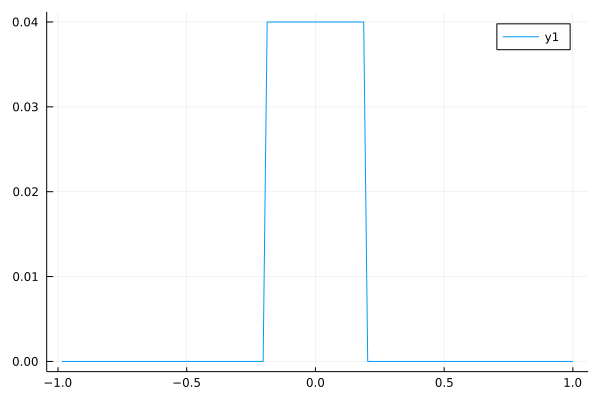

In [3]:
N = 128
h = 1/N
c = N/2
R0 = 0.1
ρ0 = zeros(N,1)

for k = 1:N
    if abs(k-c)/N < R0
        ρ0[k] = 1
    end
end 

ρ0 = (ρ0.+1E-6)/sum(ρ0[:]);
x = collect(-1:2/N:1)[2:end]
plot(x,ρ0)

## The JKO iterations

In the sequel, we generate a sequence of measures given by the iterations of the (TV-JKO) scheme
$$
\rho_{k+1}^{\tau} = \text{argmin TV}(\rho) + \frac{1}{2\tau}W^2_2\left(\rho_{k}^{\tau}, \rho\right). 
$$

In [4]:
ρ = Vector{Float64}()  # Create a vector to keep track of the evolution of the gradient flow 
append!(ρ, ρ0)         # Append initial condition


Δt,h = 0.0005,1/N              # Set the time step and the resolution of the discretization
τ = (Δt/h)*sqrt(2*log(N)/N)   # Optimal parameter for primal-dual algorithm
σ = 1/(4*τ)                   # Convergence condition for primal-dual algorithm is 2τσ < 1
max_k = 60000                 # Set maximal number of iterations, very slow convergence

# Inicializations for the primal-dual algorithm
X0 = ones(N,N)/N  
Z0 = ones(N,1)

for k=1:4
    X,Z,Xmean,Zmean = primal_dual_EntropicEuclideanBregman(X0, Z0, ρ[:,end], τ, σ, max_k, h, Δt)
    ρ = hcat(ρ, Transpose(X)*ones(N,1))
    plot(ρ[:,end])
end

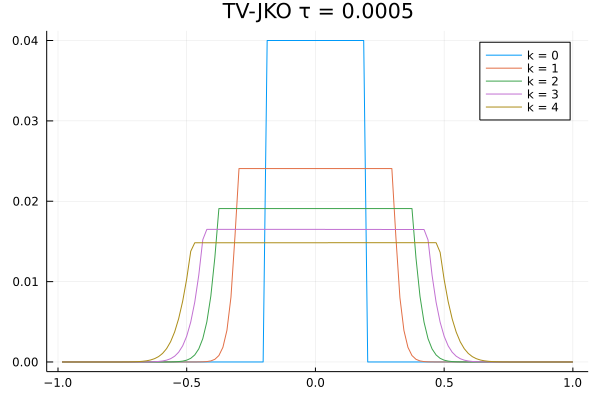

In [16]:
legend = ["k = 0" "k = 1" "k = 2" "k = 3" "k = 4"]

plot(x,ρ, title = "TV-JKO τ = 0.0005", label = legend)

In [17]:
fig = plot(x,ρ, title = "TV-JKO τ = 0.0005", label = legend)

savefig(fig, "tvjko_circ.png")